In [8]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
import japanize_matplotlib
%matplotlib inline
import seaborn as sns

In [88]:
class TrainDataset():
    def __init__(self):        
        
        # 学習データ
        data = pd.read_csv('train.csv')
        data_add = pd.read_csv('train_add.csv')
        data_new = pd.concat([data, data_add])
        
        # スタジアム
        self.stadium = pd.read_csv('stadium.csv')
        data_all = pd.merge(data_new, self.stadium, left_on='stadium', right_on='name', how='left') 
        
        # data_allのnameカラムを削除して、data_allに代入してください。
        data_all = data_all.drop(columns=['name'])
        
        # 不正データの補正 (レコード削除のパターンもあるため、ファイル読み込み直後に処理する)
        self.df = self.correction(data_all.copy())
        
        # 目的変数の外れ値は、評価データに存在しないため、init内で処理する
        self.df = self.df[self.df['y'] > 0]
        self.df['y_capa'] = self.df['y'] / self.df['capa']
        
        # 説明変数と目的変数に分割する
        df_x = self.df.drop(['y', 'y_capa'], axis=1)
        self.df_y = self.df.loc[:,['y']]
        self.df_y_capa = self.df.loc[:,['y_capa']]
        
        
        # 説明変数の量的データ、質的データ分割
        self.x_cate , self.x_cont, self.x_id = self.DataChange(df_x.copy())
        self.x_desc = self.x_cont.describe()
        
        self.x_cate_conv = self.x_cate.copy()
        self.x_cont_conv = self.x_cont.copy()
        
        self.DataConv()
        
        print(self.x_cate_conv.info())
        print(self.x_cont_conv.info())
        
    def correction(self, df):

        df['month'] = df['gameday'].apply(self.get_month)
        df['week'] = df['gameday'].apply(self.get_week)
        df['match_num'] = df['match'].apply(self.get_match)
        df['hour'] = df['time'].apply(self.get_hour)
        df['tv_num'] = df['tv'].apply(self.get_num)
        df = df.replace('ザスパ草津','ザスパクサツ群馬')
        df = df.replace('岐阜メモリアルセンター長良川球技メドウ','岐阜メモリアルセンター長良川競技場')
        
        #print('null check')
        #print(df.isnull().sum())
        #print('-------------------------')
        
        return df
    
    def DataChange(self, df_x):
        categ_cols = ['year', 'stage' , 'match', 'match_num' ,'gameday', 'time', 'home' ,'away', 'tv' , 'month' , 'week' ]
        contin_cols = ['tv_num']
        index_cols = ['id', 'capa']

        ####################################
        ##  データ分割
        ##  説明変数と目的変数に分ける。
        ##  説明変数はカテゴリデータと連続データに分ける。
        ####################################
        x_cate = df_x[categ_cols].copy()
        x_cont = df_x[contin_cols].copy()
        x_id = df_x[index_cols].copy()
        x_id = x_id.astype('int64')
        
        return x_cate , x_cont  ,x_id
    
    
    # 開催日の月を取り出す
    def get_month(self, x):
        return int(x[0:2])
    
    # 開催日の曜日を取り出す
    def get_week(self, x):
        return x[6:7]
    
    # 開催日の月を取り出す
    def get_hour(self, x):
        return int(x[0:2])
    
    # 第〇節の値を取り出して数値化する
    def get_match(self, x):
        return int(x[x.find('第') + 1: x.find('節')])
    
    # 湿度を数値化する
    def get_humidity(self, x):
        return float(x[:-1])/100
    
    # 放送するテレビ局の数を数える
    def get_num(self, x):
        return len(x.split('／'))

    def dropCol(self):
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=['gameday', 'tv'  ], axis=1)
       
        
        #self.x_cont_conv = self.x_cont_conv.drop(columns=['year'], axis=1)
        
        
    def stageConv(self):
        
        col = 'stage'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='Ｊ１']        
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # ALL ゼロがＪ２なので処理しない
        row_index = self.x_cate.index[self.x_cate[col]=='Ｊ２']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
        
        
    def monthConv(self):
        
        col = 'month'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='12']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # 12月だけ観客数が多いので、その他は０にする
        row_index = self.x_cate.index[self.x_cate[col]=='03']
        row_index = self.x_cate.index[self.x_cate[col]=='04']
        row_index = self.x_cate.index[self.x_cate[col]=='05']
        row_index = self.x_cate.index[self.x_cate[col]=='06']
        row_index = self.x_cate.index[self.x_cate[col]=='07']
        row_index = self.x_cate.index[self.x_cate[col]=='08']
        row_index = self.x_cate.index[self.x_cate[col]=='09']
        row_index = self.x_cate.index[self.x_cate[col]=='10']
        row_index = self.x_cate.index[self.x_cate[col]=='11']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
    
    def weekConv(self):
        
        col = 'week'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='土']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # 土曜日だけ観客数が多いので、その他は０にする
        row_index = self.x_cate.index[self.x_cate[col]=='日']
        row_index = self.x_cate.index[self.x_cate[col]=='月']
        row_index = self.x_cate.index[self.x_cate[col]=='火']
        row_index = self.x_cate.index[self.x_cate[col]=='水']
        row_index = self.x_cate.index[self.x_cate[col]=='木']
        row_index = self.x_cate.index[self.x_cate[col]=='金']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
    
    
    def train_Split(self):
        
        # 訓練データと検証データに分割
        x_train_cate, x_test_cate ,y_train, y_test = train_test_split(self.x_cate_conv, self.df_y, test_size=0.2, random_state=3) 
        
        # カテゴリデータと同じ行数分数値データを抽出する (id も訓練データと検証データに分ける)
        row_index = x_train_cate.index.values
        x_train_cont = self.x_cont_conv.loc[row_index, :]
        self.X_train_id = self.x_id.loc[row_index, :]
        self.X_train_id.reset_index(drop=True, inplace=True)
        y_train_capa = self.df_y_capa.loc[row_index, :]
        
        ###　検証データ
        row_index = x_test_cate.index.values
        x_test_cont = self.x_cont_conv.loc[row_index, :]
        self.X_test_id = self.x_id.loc[row_index, :]
        self.X_test_id.reset_index(drop=True, inplace=True)
        y_test_capa = self.df_y_capa.loc[row_index, :]
        
        x_train = pd.concat([x_train_cate , x_train_cont] , axis=1)
        x_test = pd.concat([x_test_cate , x_test_cont] , axis=1)
        
        self.X_train = np.array(x_train)
        self.X_test = np.array(x_test)
        self.Y_train = np.array(y_train)
        self.Y_test = np.array(y_test)
        self.Y_train_capa = np.array(y_train_capa)
        self.Y_test_capa = np.array(y_test_capa)
        
        self.coti_size = self.x_cont.shape[1]
        self.in_size  = self.X_train.shape[1]
        self.out_size = self.Y_train.shape[1]  

    def homeConv(self):
        
        col = 'home'
        
        self.x_cate_conv[col + '_01'] = 0
        self.x_cate_conv[col + '_02'] = 0
        self.x_cate_conv[col + '_03'] = 0
        self.x_cate_conv[col + '_04'] = 0
        self.x_cate_conv[col + '_05'] = 0
        
        self.x_cate_conv[col + '_06'] = 0
        self.x_cate_conv[col + '_07'] = 0
        self.x_cate_conv[col + '_08'] = 0
        self.x_cate_conv[col + '_09'] = 0
        self.x_cate_conv[col + '_10'] = 0
        
        self.x_cate_conv[col + '_11'] = 0
        self.x_cate_conv[col + '_12'] = 0
        self.x_cate_conv[col + '_13'] = 0
        self.x_cate_conv[col + '_14'] = 0
        self.x_cate_conv[col + '_15'] = 0
        
        self.x_cate_conv[col + '_16'] = 0
        self.x_cate_conv[col + '_17'] = 0
        self.x_cate_conv[col + '_18'] = 0
        self.x_cate_conv[col + '_19'] = 0
        self.x_cate_conv[col + '_20'] = 0
        
        self.x_cate_conv[col + '_21'] = 0
        self.x_cate_conv[col + '_22'] = 0
        self.x_cate_conv[col + '_23'] = 0
        self.x_cate_conv[col + '_24'] = 0
        self.x_cate_conv[col + '_25'] = 0
        
        self.x_cate_conv[col + '_26'] = 0
        self.x_cate_conv[col + '_27'] = 0
        self.x_cate_conv[col + '_28'] = 0
        self.x_cate_conv[col + '_29'] = 0
        self.x_cate_conv[col + '_30'] = 0
        
        self.x_cate_conv[col + '_31'] = 0
        self.x_cate_conv[col + '_32'] = 0
        self.x_cate_conv[col + '_33'] = 0
        self.x_cate_conv[col + '_34'] = 0
        #self.x_cate_conv[col + '_35'] = 0
        
        #self.x_cate_conv[col + '_36'] = 0
        #self.x_cate_conv[col + '_37'] = 0
        #self.x_cate_conv[col + '_38'] = 0
        #self.x_cate_conv[col + '_39'] = 0
        #self.x_cate_conv[col + '_40'] = 0
        
        #self.x_cate_conv[col + '_41'] = 0
        #self.x_cate_conv[col + '_42'] = 0
        
        row_index = self.x_cate[(self.x_cate[col]=='ベガルタ仙台') & (self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_01'] = 1        
        row_index = self.x_cate[(self.x_cate[col]=='ベガルタ仙台') & ~(self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_02'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='セレッソ大阪') & (self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_03'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='セレッソ大阪') & (self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_04'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='セレッソ大阪') & (self.x_cate['year'] == 2014)].index                
        self.x_cate_conv.loc[row_index, col + '_05'] = 1
        
        
        row_index = self.x_cate.index[self.x_cate[col]=='浦和レッズ']
        self.x_cate_conv.loc[row_index, col + '_06'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='清水エスパルス']
        self.x_cate_conv.loc[row_index, col + '_07'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ジュビロ磐田']
        self.x_cate_conv.loc[row_index, col + '_08'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='川崎フロンターレ']
        self.x_cate_conv.loc[row_index, col + '_09'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ヴァンフォーレ甲府']
        self.x_cate_conv.loc[row_index, col + '_10'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='湘南ベルマーレ']
        self.x_cate_conv.loc[row_index, col + '_11'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='名古屋グランパス']
        self.x_cate_conv.loc[row_index, col + '_12'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='松本山雅ＦＣ']
        self.x_cate_conv.loc[row_index, col + '_13'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='サガン鳥栖']
        self.x_cate_conv.loc[row_index, col + '_14'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='大宮アルディージャ']
        self.x_cate_conv.loc[row_index, col + '_15'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='ジェフユナイテッド千葉']
        self.x_cate_conv.loc[row_index, col + '_16'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='アルビレックス新潟']
        self.x_cate_conv.loc[row_index, col + '_17'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='横浜ＦＣ']
        self.x_cate_conv.loc[row_index, col + '_18'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ＦＣ岐阜']
        self.x_cate_conv.loc[row_index, col + '_19'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ロアッソ熊本']
        self.x_cate_conv.loc[row_index, col + '_20'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='京都サンガF.C.']
        self.x_cate_conv.loc[row_index, col + '_21'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='横浜Ｆ・マリノス') & (self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_22'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='横浜Ｆ・マリノス') & ~(self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_23'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='徳島ヴォルティス') & (self.x_cate['year'] == 2014)].index
        self.x_cate_conv.loc[row_index, col + '_24'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='徳島ヴォルティス') & ~(self.x_cate['year'] == 2014)].index
        self.x_cate_conv.loc[row_index, col + '_25'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='ＦＣ東京']
        self.x_cate_conv.loc[row_index, col + '_26'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ファジアーノ岡山']
        self.x_cate_conv.loc[row_index, col + '_27'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='鹿島アントラーズ']
        self.x_cate_conv.loc[row_index, col + '_28'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='']
        row_index = self.x_cate[(self.x_cate[col]=='ヴィッセル神戸') & (self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_29'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='ヴィッセル神戸') & ~(self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_30'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='柏レイソル']
        self.x_cate_conv.loc[row_index, col + '_31'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='ガンバ大阪') & (self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_32'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='ガンバ大阪') & (self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_33'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='ガンバ大阪') & (self.x_cate['year'] == 2014)].index
        self.x_cate_conv.loc[row_index, col + '_34'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='水戸ホーリーホック']
        row_index = self.x_cate.index[self.x_cate[col]=='コンサドーレ札幌']
        row_index = self.x_cate.index[self.x_cate[col]=='Ｖ・ファーレン長崎']
        row_index = self.x_cate.index[self.x_cate[col]=='サンフレッチェ広島']
        row_index = self.x_cate.index[self.x_cate[col]=='大分トリニータ']
        row_index = self.x_cate.index[self.x_cate[col]=='東京ヴェルディ']
        row_index = self.x_cate.index[self.x_cate[col]=='アビスパ福岡']
        row_index = self.x_cate.index[self.x_cate[col]=='愛媛ＦＣ']
        row_index = self.x_cate.index[self.x_cate[col]=='ギラヴァンツ北九州']
        row_index = self.x_cate.index[self.x_cate[col]=='栃木ＳＣ']
        row_index = self.x_cate.index[self.x_cate[col]=='ＦＣ町田ゼルビア']
        row_index = self.x_cate.index[self.x_cate[col]=='ザスパクサツ群馬']        
        row_index = self.x_cate.index[self.x_cate[col]=='モンテディオ山形']
        row_index = self.x_cate.index[self.x_cate[col]=='ガイナーレ鳥取']
        row_index = self.x_cate.index[self.x_cate[col]=='カターレ富山']
        row_index = self.x_cate.index[self.x_cate[col]=='カマタマーレ讃岐']     
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)

    def mutchCol(self):
        
        col = 'match_num'
        
        self.x_cate_conv[col + '_01'] = 0
        self.x_cate_conv[col + '_02'] = 0
        self.x_cate_conv[col + '_03'] = 0
        self.x_cate_conv[col + '_04'] = 0
        self.x_cate_conv[col + '_05'] = 0
        
        #self.x_cate_conv[col + '_06'] = 0
        #self.x_cate_conv[col + '_07'] = 0
        #self.x_cate_conv[col + '_08'] = 0
        #self.x_cate_conv[col + '_09'] = 0
        #self.x_cate_conv[col + '_10'] = 0
        

        row_index = self.x_cate[(self.x_cate[col]==1)].index
        self.x_cate_conv.loc[row_index, col + '_01'] = 1   
        row_index = self.x_cate[(self.x_cate[col]==2)].index
        self.x_cate_conv.loc[row_index, col + '_01'] = 1 
        

        rrow_index = self.x_cate[(self.x_cate[col]==11) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_02'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==12) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_02'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==13) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_02'] = 1
        
        
        rrow_index = self.x_cate[(self.x_cate[col]==20) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_03'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==21) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_03'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==22) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_03'] = 1
        
        rrow_index = self.x_cate[(self.x_cate[col]==33) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_04'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==34) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_04'] = 1
        
        rrow_index = self.x_cate[(self.x_cate[col]==41) & (self.x_cate['stage'] == 'Ｊ２')].index
        self.x_cate_conv.loc[row_index, col + '_05'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==42) & (self.x_cate['stage'] == 'Ｊ２')].index
        self.x_cate_conv.loc[row_index, col + '_05'] = 1
        
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
        
    def addCol(self):
        
        col = 'special'
        
        
        self.x_cate_conv['tokusima'] = 0
        self.x_cate_conv['tokusima'][(self.x_cate_conv['away'] == '徳島ヴォルティス') & (self.x_cate['year'] == 2014)] = 1
        
        
    def DataConv(self):
        self.addCol()
        self.mutchCol()
        self.stageConv()
        
        self.monthConv()
        self.weekConv()
        self.homeConv()
        self.dropCol()        
        self.train_Split()
        

In [89]:
train_dataset = TrainDataset()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 0 to 1952
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          1952 non-null   int64 
 1   match         1952 non-null   object
 2   time          1952 non-null   object
 3   away          1952 non-null   object
 4   tokusima      1952 non-null   int64 
 5   match_num_01  1952 non-null   int64 
 6   match_num_02  1952 non-null   int64 
 7   match_num_03  1952 non-null   int64 
 8   match_num_04  1952 non-null   int64 
 9   match_num_05  1952 non-null   int64 
 10  stage_1       1952 non-null   int64 
 11  month_1       1952 non-null   int64 
 12  week_1        1952 non-null   int64 
 13  home_01       1952 non-null   int64 
 14  home_02       1952 non-null   int64 
 15  home_03       1952 non-null   int64 
 16  home_04       1952 non-null   int64 
 17  home_05       1952 non-null   int64 
 18  home_06       1952 non-null   int64 
 19  home_0

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\ipykernel_launcher.py:405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [90]:
train_dataset.df.describe()

,id,y,year,capa,month,match_num,hour,tv_num,y_capa
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,15049.109631,10635.003586,2012.819672,25669.076332,6.318648,18.057889,16.311475,2.656762,0.420898
std,646.258703,8100.815840,0.757848,13994.077172,2.500005,11.151684,2.310654,0.715226,0.213901
min,13994.000000,1104.000000,2012.000000,3560.000000,3.000000,1.000000,12.000000,1.000000,0.050610
25%,14481.750000,4690.750000,2012.000000,15589.000000,4.000000,9.000000,14.000000,2.000000,0.246491
50%,15043.500000,8600.500000,2013.000000,20246.000000,6.000000,17.000000,16.000000,3.000000,0.387808
75%,15531.250000,13472.250000,2013.000000,30132.000000,8.000000,27.000000,19.000000,3.000000,0.572693
max,16238.000000,62632.000000,2014.000000,72327.000000,12.000000,42.000000,20.000000,5.000000,0.979000


In [91]:
train_dataset.df.describe(include='O')

,stage,match,gameday,time,home,away,stadium,tv,address,week
count,1952,1952,1952,1952,1952,1952,1952,1952,1952,1952
unique,2,73,212,63,42,42,58,227,58,7
top,Ｊ２,第２節第１日,05/06(月・休),19:04,愛媛ＦＣ,栃木ＳＣ,味の素スタジアム,スカパー！／スカパー！プレミアムサービス,東京都調布市西町376-3,土
freq,1188,60,20,292,55,55,79,915,79,824


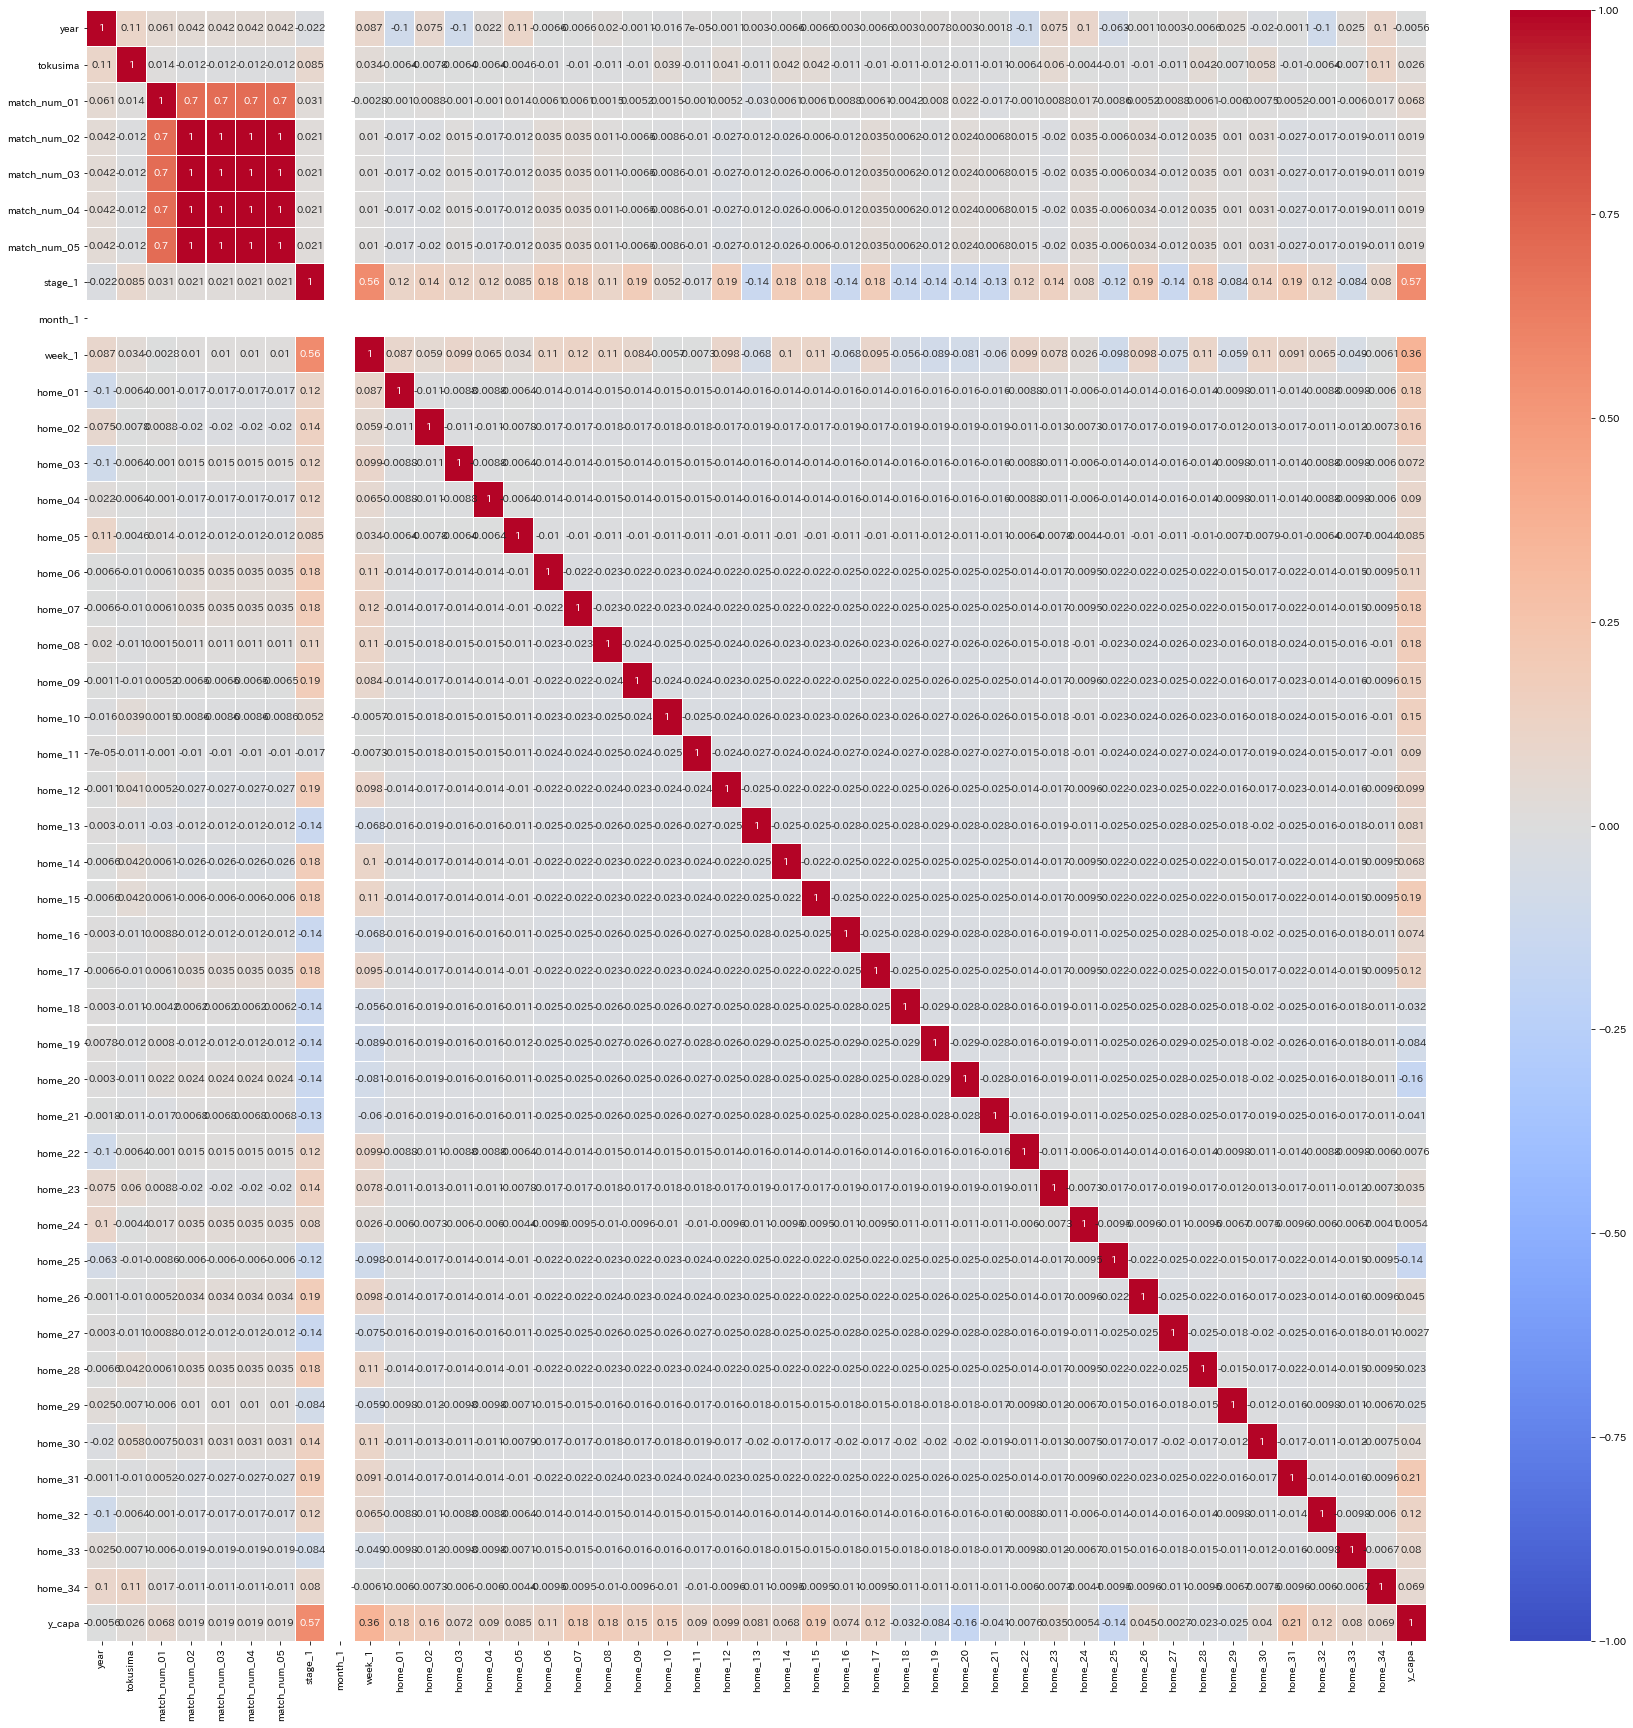

In [92]:
plt.figure(figsize=(30,30))
df_sns = train_dataset.x_cate_conv.copy()
df_sns = pd.concat([df_sns , train_dataset.df_y_capa], axis=1)
sns.heatmap(df_sns.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()


<Figure size 1440x1440 with 0 Axes>

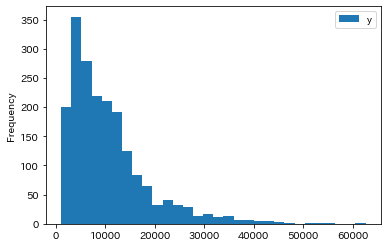

In [13]:
plt.figure(figsize=(20,20))
train_dataset.df_y.plot.hist(bins=30)
plt.show()

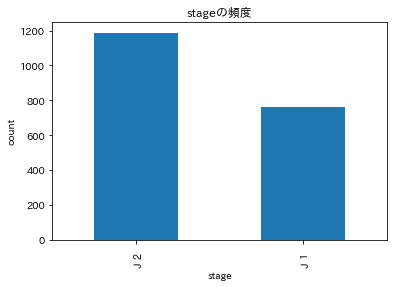

In [14]:
col = 'stage'

# 頻度値を算出
counts = train_dataset.df[col].value_counts()

# 棒グラフの可視化
counts.plot.bar(title=col + 'の頻度')

#x軸とy軸に名前を付与
plt.xlabel(col)
plt.ylabel('count')

# 可視化結果を表示する為に必要な関数
plt.show()

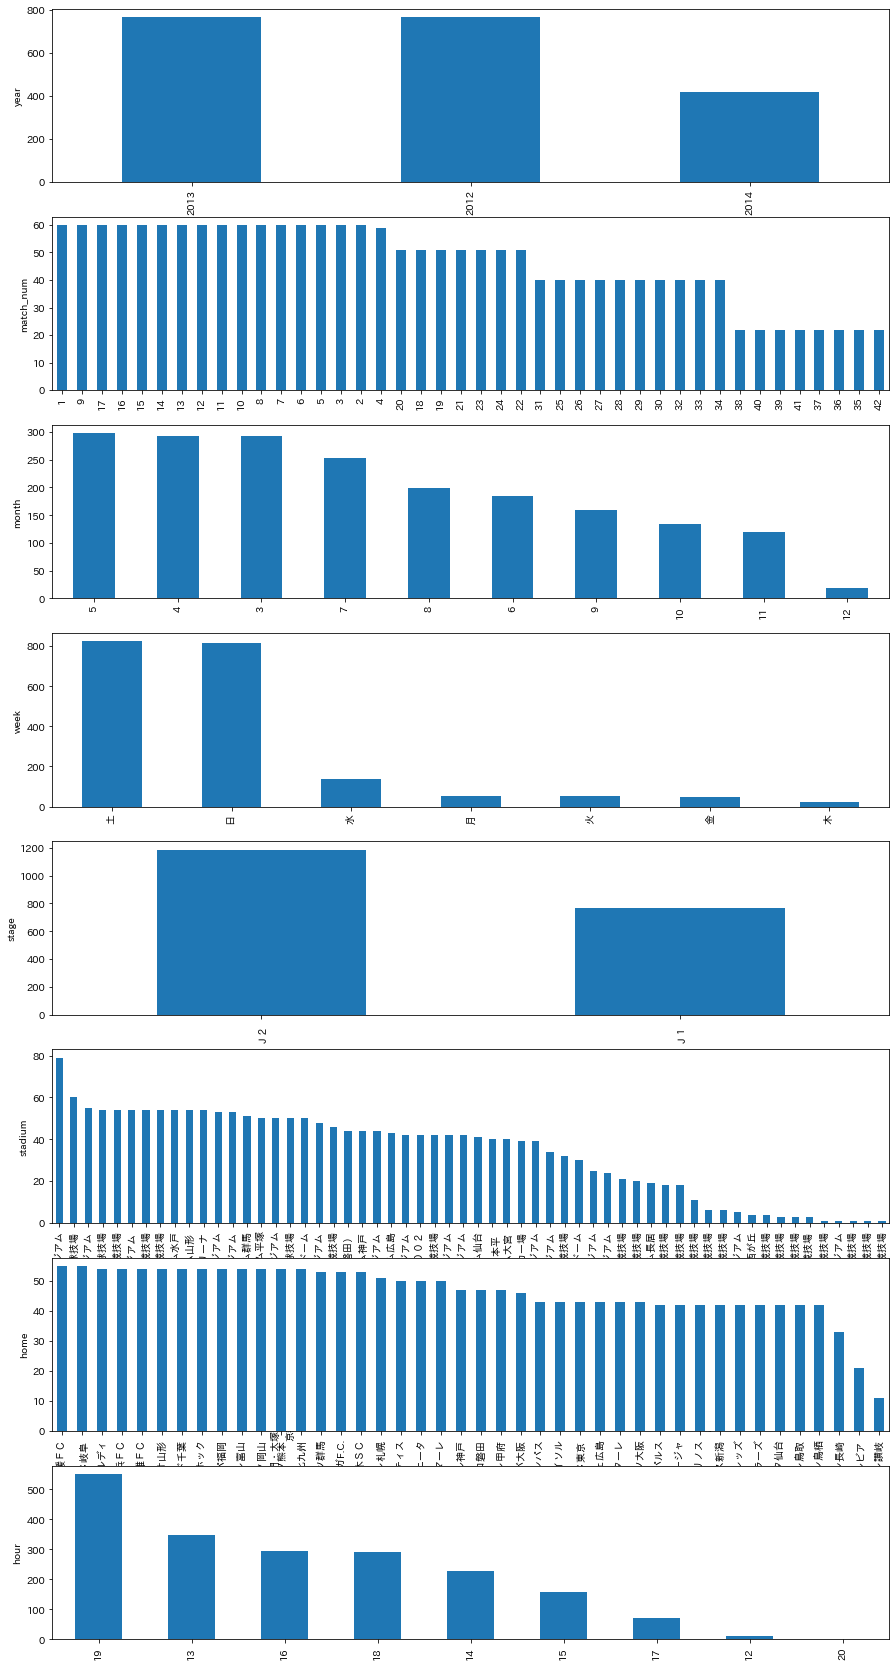

In [15]:
cols = ['year', 'match_num', 'month', 'week', 'stage', 'stadium', 'home' ,'hour']

col_val=1
row_val=len(cols)

i = 0
plt.figure(figsize=(15,30))

for col in cols:
    plt.subplot(row_val, col_val, i + 1)  # 2行5列、i+1の位置  (画像表示の指示)
    
    # 頻度値を算出
    counts = train_dataset.df[col].value_counts()

    # 棒グラフの可視化
    counts.plot.bar()

    #x軸とy軸に名前を付与
    plt.ylabel(col)
    

    i += 1    
    
# 可視化結果を表示する為に必要な関数
plt.show()

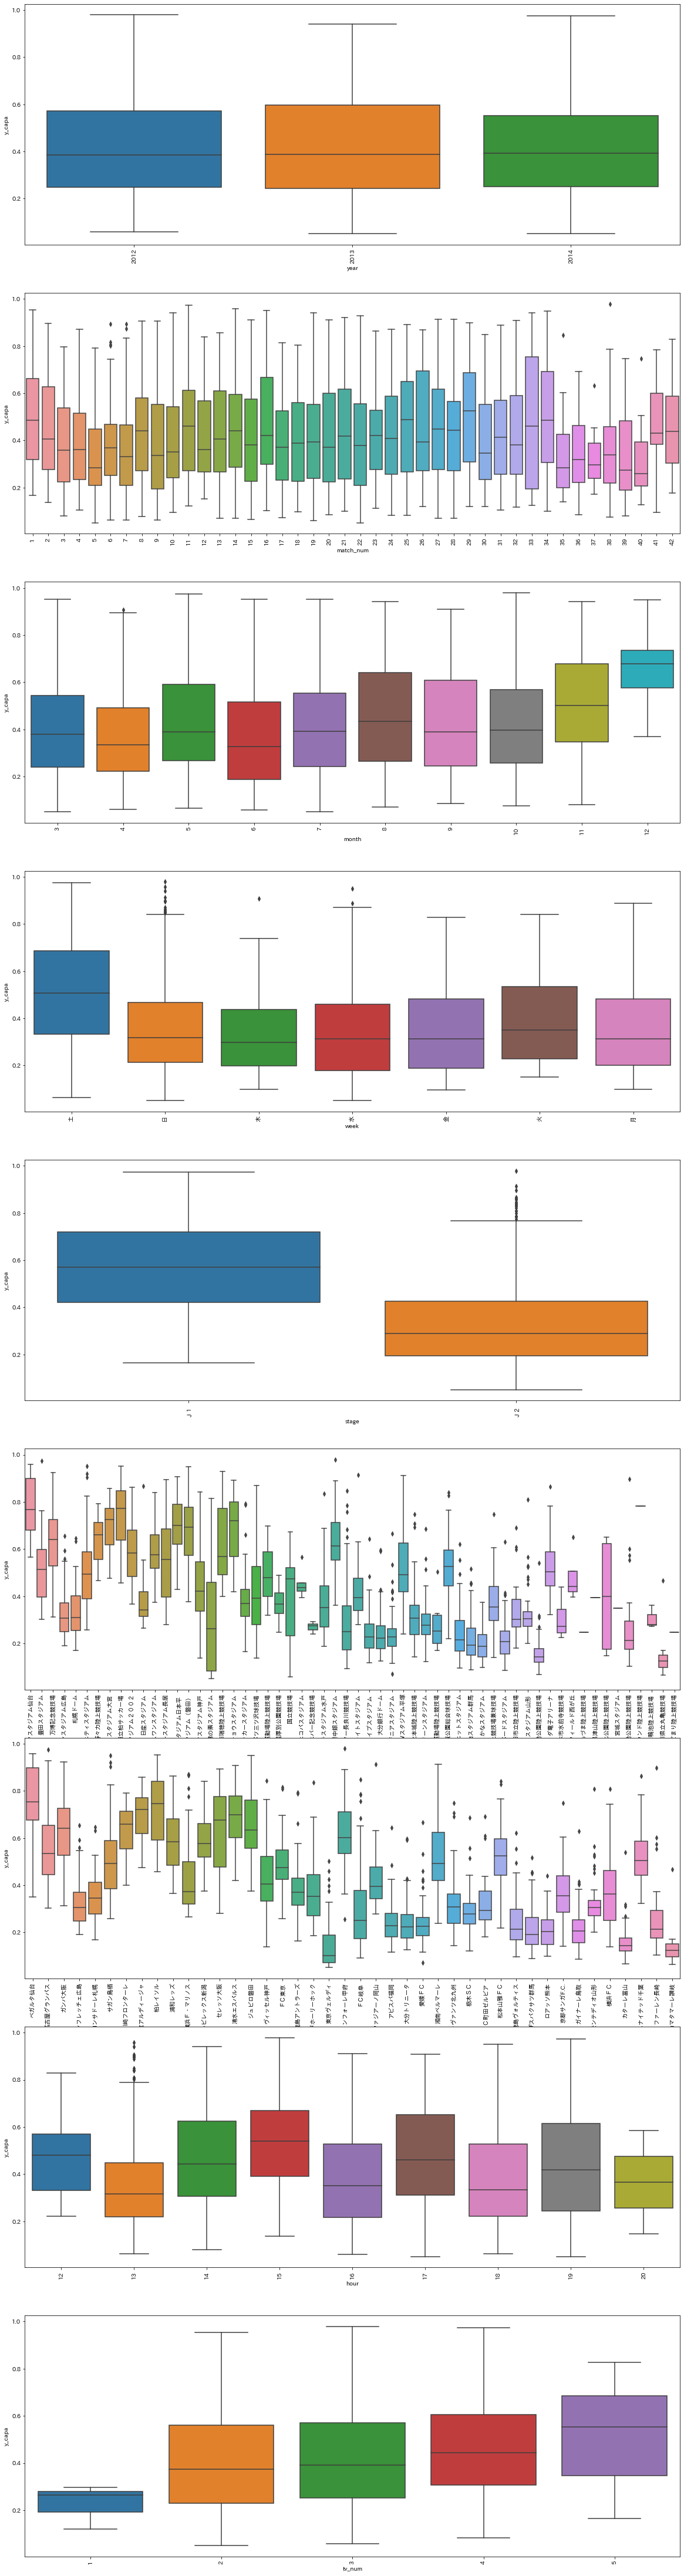

In [16]:
cols = ['year', 'match_num', 'month', 'week', 'stage', 'stadium', 'home' ,'hour', 'tv_num']

col_val=1
row_val=len(cols)

i = 0
plt.figure(figsize=(20,80))

for col in cols:
    plt.subplot(row_val, col_val, i + 1)  # 2行5列、i+1の位置  (画像表示の指示)
    
    #  全レコード
    sns.boxplot(x=col, y='y_capa'     ,data=train_dataset.df)
    plt.xticks(rotation=90)
    #if (i + 1) == 1:
    #    plt.title('All')
    #plt.ylabel(col)
    i += 1    


plt.show()

In [22]:
train_dataset.df['home'][ (train_dataset.df['stage'] == 'Ｊ１') ].unique()

array(['ベガルタ仙台', '名古屋グランパス', 'ガンバ大阪', 'サンフレッチェ広島', 'コンサドーレ札幌', 'サガン鳥栖',
       '川崎フロンターレ', '大宮アルディージャ', '柏レイソル', '浦和レッズ', '横浜Ｆ・マリノス', 'アルビレックス新潟',
       'セレッソ大阪', '清水エスパルス', 'ジュビロ磐田', 'ヴィッセル神戸', 'ＦＣ東京', '鹿島アントラーズ',
       '大分トリニータ', 'ヴァンフォーレ甲府', '湘南ベルマーレ', '徳島ヴォルティス'], dtype=object)

In [23]:
train_dataset.df['home'][ (train_dataset.df['stage'] == 'Ｊ２') ].unique()

array(['水戸ホーリーホック', '東京ヴェルディ', 'ヴァンフォーレ甲府', 'ＦＣ岐阜', 'ファジアーノ岡山', 'アビスパ福岡',
       '大分トリニータ', '愛媛ＦＣ', '湘南ベルマーレ', 'ギラヴァンツ北九州', '栃木ＳＣ', 'ＦＣ町田ゼルビア',
       '松本山雅ＦＣ', '徳島ヴォルティス', 'ザスパクサツ群馬', 'ロアッソ熊本', '京都サンガF.C.', 'ガイナーレ鳥取',
       'モンテディオ山形', '横浜ＦＣ', 'カターレ富山', 'ジェフユナイテッド千葉', 'ガンバ大阪', 'ヴィッセル神戸',
       'コンサドーレ札幌', 'Ｖ・ファーレン長崎', 'ジュビロ磐田', 'カマタマーレ讃岐'], dtype=object)

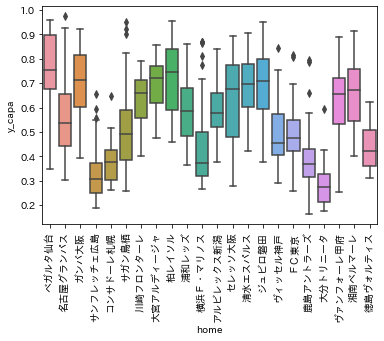

In [25]:
sns.boxplot(x='home', y='y_capa'     ,data=train_dataset.df[(train_dataset.df['stage'] == 'Ｊ１') ])
plt.xticks(rotation=90)
plt.show()

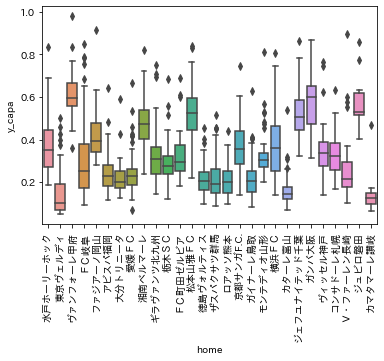

In [26]:
sns.boxplot(x='home', y='y_capa'     ,data=train_dataset.df[(train_dataset.df['stage'] == 'Ｊ２') ])
plt.xticks(rotation=90)
plt.show()

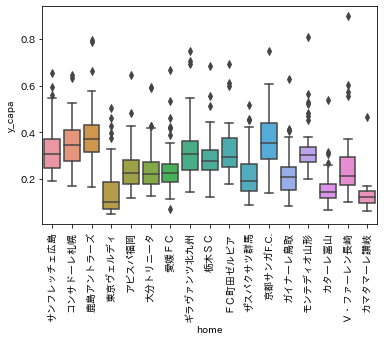

In [41]:
# 中央値が０．４以下
row_index = train_dataset.df[(train_dataset.df['home'] == '鹿島アントラーズ') | \
                             (train_dataset.df['home'] == 'コンサドーレ札幌') | \
                             (train_dataset.df['home'] == 'Ｖ・ファーレン長崎') | \
                             (train_dataset.df['home'] == 'サンフレッチェ広島') | \
                             (train_dataset.df['home'] == '愛媛ＦＣ') | \
                             (train_dataset.df['home'] == '大分トリニータ') | \
                             (train_dataset.df['home'] == '東京ヴェルディ') | \
                             (train_dataset.df['home'] == 'ギラヴァンツ北九州') | \
                             (train_dataset.df['home'] == '栃木ＳＣ') | \
                             (train_dataset.df['home'] == 'ＦＣ町田ゼルビア') | \
                             (train_dataset.df['home'] == 'ザスパクサツ群馬') | \
                             (train_dataset.df['home'] == '京都サンガF.C.') | \
                             (train_dataset.df['home'] == 'モンテディオ山形') | \
                             (train_dataset.df['home'] == 'ガイナーレ鳥取') | \
                             (train_dataset.df['home'] == 'カターレ富山') | \
                             (train_dataset.df['home'] == 'カマタマーレ讃岐') | \
                             (train_dataset.df['home'] == 'アビスパ福岡') \
                            ].index

sns.boxplot(x='home', y='y_capa'     ,data=train_dataset.df.loc[row_index, :])
plt.xticks(rotation=90)
plt.show()

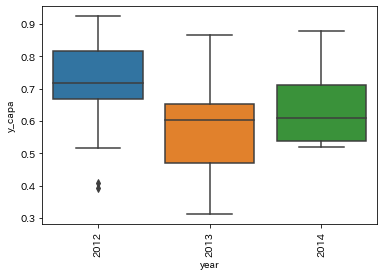

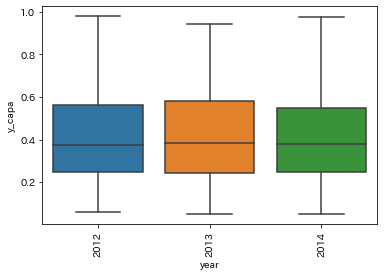

In [87]:
row_index = train_dataset.df[(train_dataset.df['home'] == 'ガンバ大阪') ].index
sns.boxplot(x='year', y='y_capa'     ,data=train_dataset.df.loc[row_index, :])
plt.xticks(rotation=90)
plt.show()


row_index = train_dataset.df[(train_dataset.df['home'] != 'ガンバ大阪') ].index
sns.boxplot(x='year', y='y_capa'     ,data=train_dataset.df.loc[row_index, :])
plt.xticks(rotation=90)
plt.show()

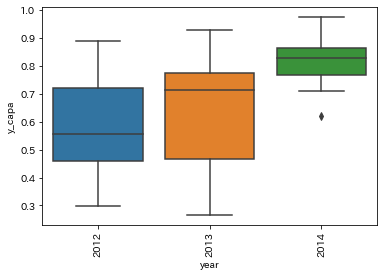

In [61]:
row_index = train_dataset.df[(train_dataset.df['away'] == 'セレッソ大阪') ].index

sns.boxplot(x='year', y='y_capa'     ,data=train_dataset.df.loc[row_index, :])
plt.xticks(rotation=90)
plt.show()

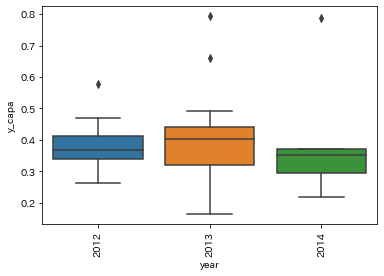

In [55]:
row_index = train_dataset.df[(train_dataset.df['home'] == '鹿島アントラーズ') ].index

sns.boxplot(x='year', y='y_capa'     ,data=train_dataset.df.loc[row_index, :])
plt.xticks(rotation=90)
plt.show()

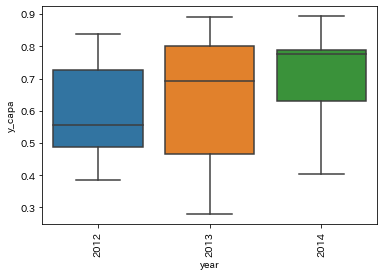

In [56]:
row_index = train_dataset.df[(train_dataset.df['home'] == 'セレッソ大阪') ].index

sns.boxplot(x='year', y='y_capa'     ,data=train_dataset.df.loc[row_index, :])
plt.xticks(rotation=90)
plt.show()

In [18]:
train_dataset.df['stadium'].unique()

array(['ユアテックスタジアム仙台', '豊田スタジアム', '万博記念競技場', 'エディオンスタジアム広島', '札幌ドーム',
       'ベストアメニティスタジアム', '等々力陸上競技場', 'ＮＡＣＫ５スタジアム大宮', '日立柏サッカー場',
       '埼玉スタジアム２００２', '日産スタジアム', 'デンカビッグスワンスタジアム', 'ヤンマースタジアム長居',
       'ＩＡＩスタジアム日本平', 'ヤマハスタジアム（磐田）', 'ノエビアスタジアム神戸', '味の素スタジアム',
       '名古屋市瑞穂陸上競技場', 'キンチョウスタジアム', '県立カシマサッカースタジアム', 'ニッパツ三ツ沢球技場',
       '佐賀県総合運動場陸上競技場', '札幌厚別公園競技場', '国立競技場', 'エコパスタジアム',
       '神戸総合運動公園ユニバー記念競技場', 'ケーズデンキスタジアム水戸', '山梨中銀スタジアム',
       '岐阜メモリアルセンター長良川競技場', 'シティライトスタジアム', 'レベルファイブスタジアム', '大分銀行ドーム',
       'ニンジニアスタジアム', 'Ｓｈｏｎａｎ\u3000ＢＭＷスタジアム平塚', '北九州市立本城陸上競技場',
       '栃木県グリーンスタジアム', '駒沢オリンピック公園総合運動場陸上競技場', '松本平広域公園総合球技場',
       '鳴門・大塚スポーツパーク\u3000ポカリスエットスタジアム', '正田醤油スタジアム群馬', 'うまかな・よかなスタジアム',
       '京都市西京極総合運動公園陸上競技場兼球技場', 'とりぎんバードスタジアム', '町田市立陸上競技場',
       'ＮＤソフトスタジアム山形', '富山県総合運動公園陸上競技場', 'フクダ電子アリーナ', '熊本市水前寺競技場',
       '味の素フィールド西が丘', '福島県営あづま陸上競技場', '岡山県津山陸上競技場', '熊谷スポーツ文化公園陸上競技場',
       '宮城スタジアム', '長崎県立総合運動公園陸上競技場', '大垣市浅中公園総合グラウンド陸上競技場',
       '鹿児島県立鴨池陸上競技場 ',

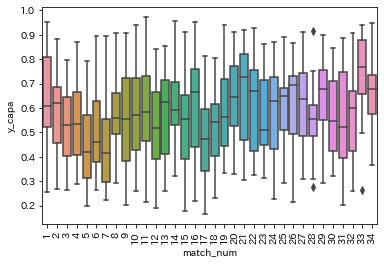

In [58]:
sns.boxplot(x='match_num', y='y_capa'     ,data=train_dataset.df[(train_dataset.df['stage'] == 'Ｊ１') ])
plt.xticks(rotation=90)
plt.show()

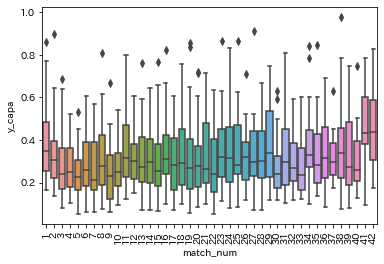

In [59]:
sns.boxplot(x='match_num', y='y_capa'     ,data=train_dataset.df[(train_dataset.df['stage'] == 'Ｊ２') ])
plt.xticks(rotation=90)
plt.show()

In [19]:
train_dataset.df.corr()

,id,y,year,capa,month,match_num,hour,tv_num,y_capa
id,1.000000,-0.176920,0.942649,-0.111546,-0.097166,-0.032474,-0.089048,-0.537001,-0.149489
y,-0.176920,1.000000,0.003211,0.688290,0.105861,-0.044138,0.029106,0.142387,0.604283
year,0.942649,0.003211,1.000000,0.014548,-0.259396,-0.258279,-0.106942,-0.496281,-0.005641
capa,-0.111546,0.688290,0.014548,1.000000,0.006253,-0.088082,0.021499,0.071603,-0.056506
month,-0.097166,0.105861,-0.259396,0.006253,1.000000,0.957339,0.218918,-0.072669,0.136379
match_num,-0.032474,-0.044138,-0.258279,-0.088082,0.957339,1.000000,0.204839,-0.093259,0.010246
hour,-0.089048,0.029106,-0.106942,0.021499,0.218918,0.204839,1.000000,-0.103685,0.032309
tv_num,-0.537001,0.142387,-0.496281,0.071603,-0.072669,-0.093259,-0.103685,1.000000,0.093476
y_capa,-0.149489,0.604283,-0.005641,-0.056506,0.136379,0.010246,0.032309,0.093476,1.000000


In [ ]:
col1 = 'match_num'
col2 = 'y'

plt.figure(figsize=(15,15))
plt.scatter(train_dataset.df.loc[:, col1], train_dataset.df.loc[:, col2], label=col1)      
plt.legend()
plt.xlabel(col1)
plt.ylabel(col2) 

plt.show()


In [ ]:
col1 = 'humidity'
col2 = 'y'

plt.figure(figsize=(15,15))
plt.scatter(train_dataset.df.loc[:, col1], train_dataset.df.loc[:, col2], label=col1)      
plt.legend()
plt.xlabel(col1)
plt.ylabel(col2) 

plt.show()


In [ ]:
col1 = 'tv_num'
col2 = 'y'

plt.figure(figsize=(15,15))
plt.scatter(train_dataset.df.loc[:, col1], train_dataset.df.loc[:, col2], label=col1)      
plt.legend()
plt.xlabel(col1)
plt.ylabel(col2) 

plt.show()
